*** 
# Assignment 3: Dataset #1 - Abalone Data Set
*** 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import time
import warnings
from pandas.plotting import scatter_matrix
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA, FastICA as fica
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, homogeneity_score, rand_score, v_measure_score, calinski_harabasz_score, mean_squared_error
from sklearn.mixture import GaussianMixture as expected_max
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, train_test_split, validation_curve, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection as grp, SparseRandomProjection as srp, johnson_lindenstrauss_min_dim as jrp
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

*** 
## DATA EXPLORATION/DISCOVERY
*** 

In [2]:
# abalone.data did not include columns
df = pd.read_csv('../data/abalone.data')
df.columns = ['sex','length','diameter','height','whole weight','shucked weight','viscera weight','shell weight', 'rings']

In [3]:
# confirm number of rows and columns as indicated by UCI
df.shape

(4176, 9)

In [4]:
# check if any value are null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4176 non-null   object 
 1   length          4176 non-null   float64
 2   diameter        4176 non-null   float64
 3   height          4176 non-null   float64
 4   whole weight    4176 non-null   float64
 5   shucked weight  4176 non-null   float64
 6   viscera weight  4176 non-null   float64
 7   shell weight    4176 non-null   float64
 8   rings           4176 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
# get statistical summary of the dataset per each column
df.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.00000,4176.000000,4176.000000,4176.000000
mean,0.524009,0.407892,0.139527,0.828818,0.35940,0.180613,0.238852,9.932471
std,0.120103,0.099250,0.041826,0.490424,0.22198,0.109620,0.139213,3.223601
min,0.075000,0.055000,0.000000,0.002000,0.00100,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.18600,0.093375,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799750,0.33600,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153250,0.50200,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.48800,0.760000,1.005000,29.000000


M    1527
I    1342
F    1307
Name: sex, dtype: int64


Text(0, 0.5, 'Frequency')

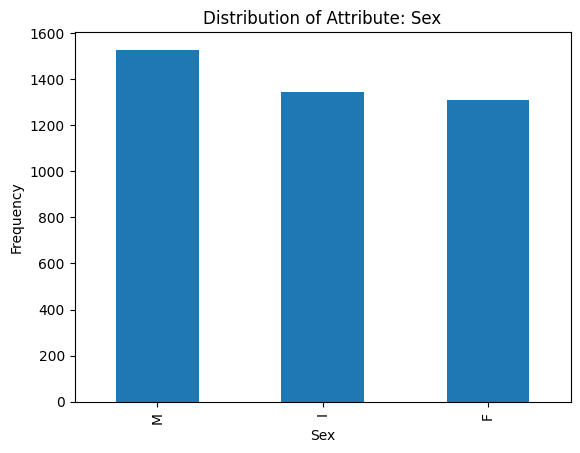

In [6]:
# determine if data is balanced in respect to target variable (sex)
print(df['sex'].value_counts())
ax = df['sex'].value_counts().plot(title='Distribution of Attribute: Sex', kind='bar')
ax.set_xlabel('Sex')
ax.set_ylabel('Frequency')

array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'diameter'}>,
        <AxesSubplot: title={'center': 'height'}>],
       [<AxesSubplot: title={'center': 'whole weight'}>,
        <AxesSubplot: title={'center': 'shucked weight'}>,
        <AxesSubplot: title={'center': 'viscera weight'}>],
       [<AxesSubplot: title={'center': 'shell weight'}>,
        <AxesSubplot: title={'center': 'rings'}>, <AxesSubplot: >]],
      dtype=object)

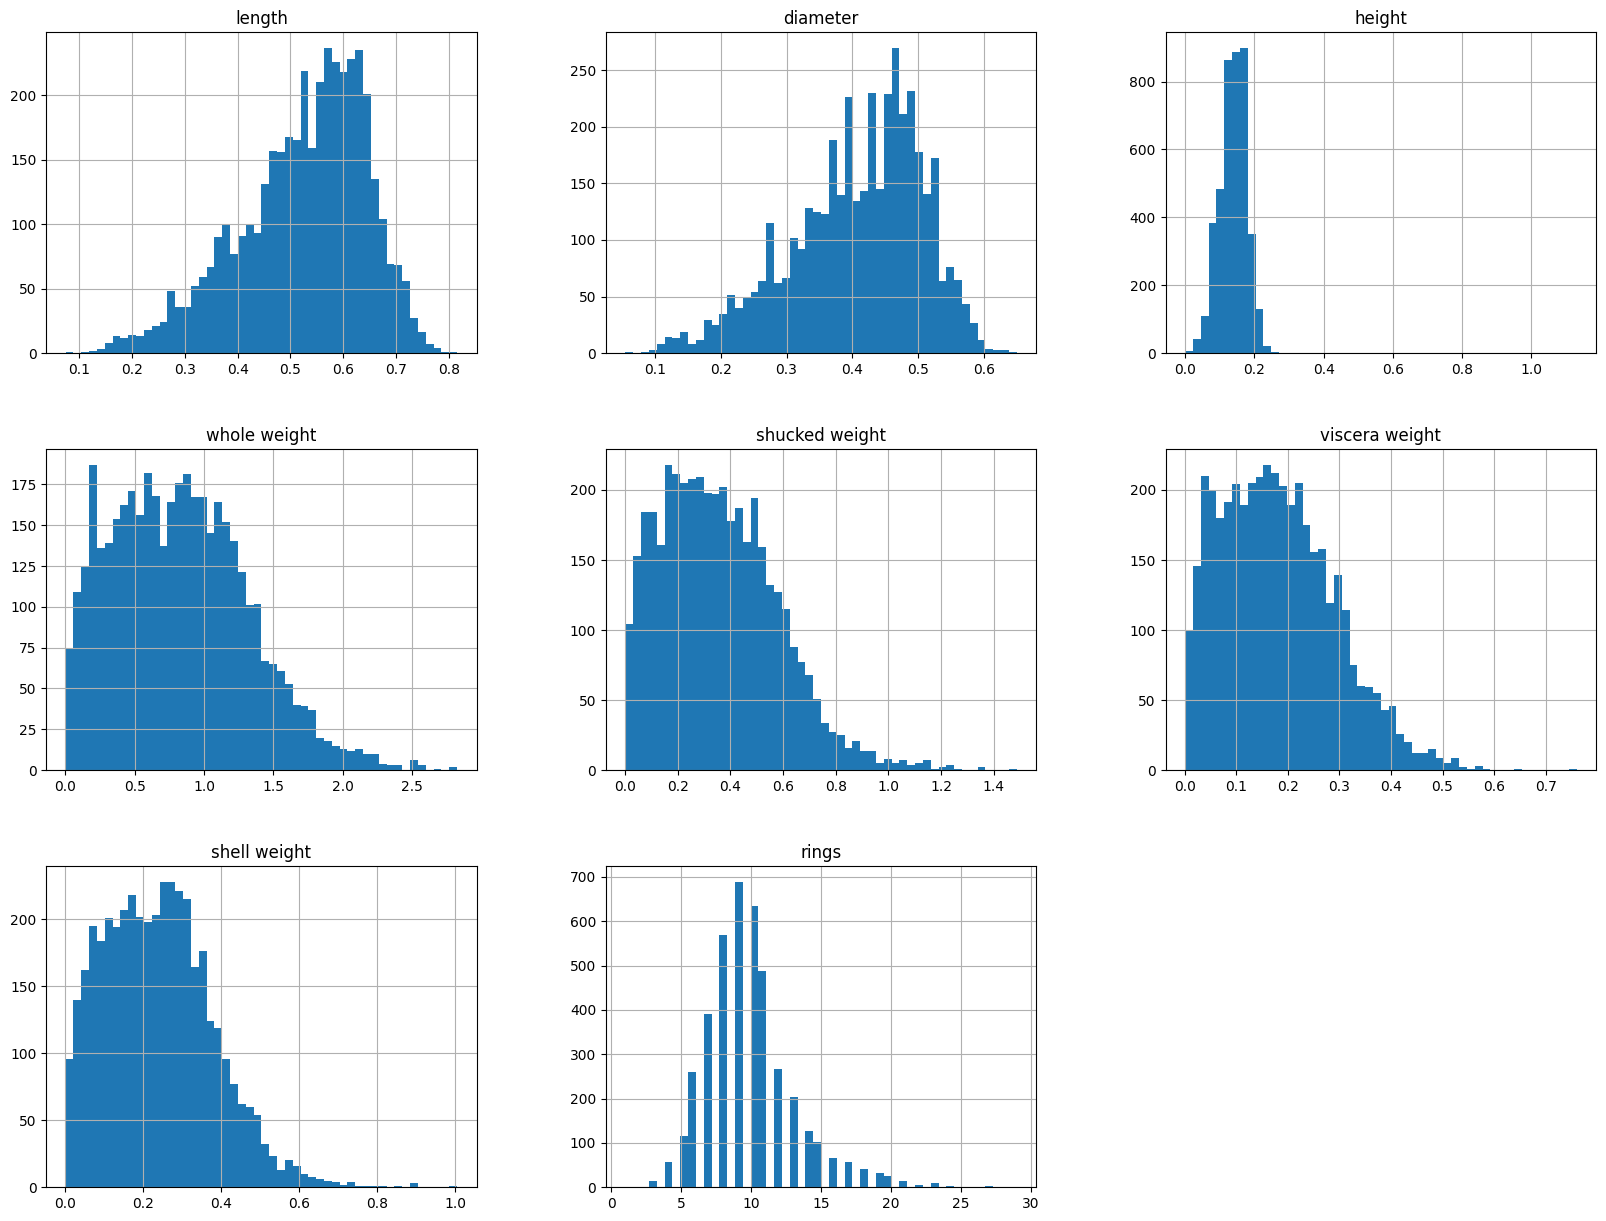

In [7]:
# understand the distribution of rest of data
df.hist(bins=50, figsize=(20,15))

*** 
## DATA PREPARATION
***

In [8]:
# X includes input/features
X = np.asarray(df.iloc[:,1:])
# y includes target class/label
y = np.asarray(df['sex'])

In [9]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [10]:
# standardize dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
# confirm data after train test split
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (3340, 8)
X_test: (836, 8)
y_train: (3340,)
y_test: (836,)


*** 
## Custom Functions
***

In [12]:
# plots learning curve showing performance vs. training size
def get_learning_curve_size(clf, clf_name, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=37), scoring="accuracy", train_sizes=np.linspace(start=0.1, stop=1.0, num=5)):
    """
    uses sklearn's learning_curve() to train clf using various sizes of training data
    
    Parameters
    ----------
    train_sizes : array-like of shape (n_ticks,) - see next line
        By default, it's [0.1   0.325 0.55  0.775 1.]
        Think of each float as percentage of total training data.
        So starts at 10%, increases by 22.5% every trial until reaching 100%
    
    cv : int, cross-validation generator/iterable
        - if int, specifies number of folds
    
    """
    sizes, training_scores, valid_scores = learning_curve(clf, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    # average training & validation scores
    avg_training_score = np.mean(training_scores, axis=1)
    avg_valid_scores = np.mean(valid_scores, axis=1)

    # plot and show
    plt.plot(sizes, avg_training_score, color="blue", label="Training Performance")
    plt.plot(sizes, avg_valid_scores, color="red", label="Validation Performance")
    plt.title("Training Size Learning Curve for {}".format(clf_name))
    plt.xlabel("Training Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    

# plots loss curve showing loss vs. iteration
def get_loss_curve(clf, clf_name):
    """
    uses MLPClassifier's loss_curve_ attribute to plot accuracy over iterations
    purpose of this function is to plot performance over time and therefore iterations.
   
    """
    # plot and show
    loss_curve = pd.DataFrame(clf.loss_curve_)
    loss_curve = loss_curve.set_axis(['Neural Network Performance'], axis=1, inplace=False)
    loss_curve.plot()
    plt.title("Iterative Loss Curve for {}".format(clf_name))
    plt.xlabel("Iterations"), plt.ylabel("Loss"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()    
    
def run_dummy_classifier(X_train, y_train, X_test, y_test):
    # initialize
    dt_clf = DecisionTreeClassifier(random_state=37)
    # start timer for training
    start = time.time()
    # train classifier
    dt_clf.fit(X_train, y_train)
    # end timer for training
    end = time.time()
    # print total time for training
    print(f"Total Training Time: {round(end-start, 5)}s")

    # start timer for testing
    start = time.time()
    # make prediction
    y_pred = dt_clf.predict(X_test)
    # end timer for testing
    end = time.time()
    # print total time for testing
    print(f"Total Testing Time: {round(end-start, 5)}s")
    # evaluate model performance on test data
    print("Accuracy using test set:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

*** 
## PART I: Clustering Algorithms
***
***
### 1.1 K-Means Clustering on dataset #1
*** 

In [13]:
X

array([[ 0.35  ,  0.265 ,  0.09  , ...,  0.0485,  0.07  ,  7.    ],
       [ 0.53  ,  0.42  ,  0.135 , ...,  0.1415,  0.21  ,  9.    ],
       [ 0.44  ,  0.365 ,  0.125 , ...,  0.114 ,  0.155 , 10.    ],
       ...,
       [ 0.6   ,  0.475 ,  0.205 , ...,  0.2875,  0.308 ,  9.    ],
       [ 0.625 ,  0.485 ,  0.15  , ...,  0.261 ,  0.296 , 10.    ],
       [ 0.71  ,  0.555 ,  0.195 , ...,  0.3765,  0.495 , 12.    ]])

In [14]:
y

array(['M', 'F', 'M', ..., 'M', 'F', 'M'], dtype=object)

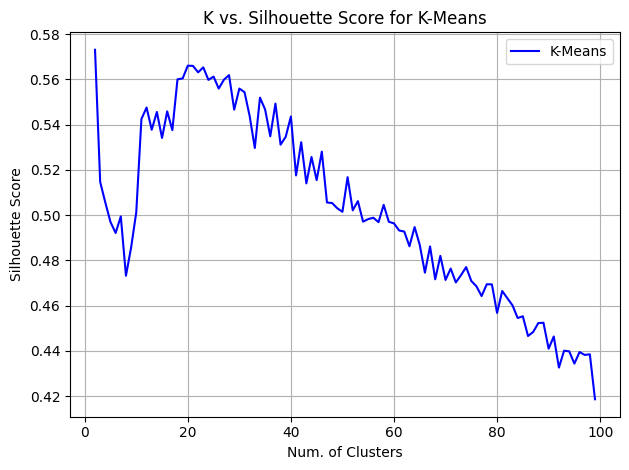

In [15]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 100, 1)
sil_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(X)
    sil_scores.append(silhouette_score(X, kmeans.labels_))
    

plt.plot(k_values, sil_scores, color="blue", label="K-Means")
plt.title("K vs. Silhouette Score for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Silhouette Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

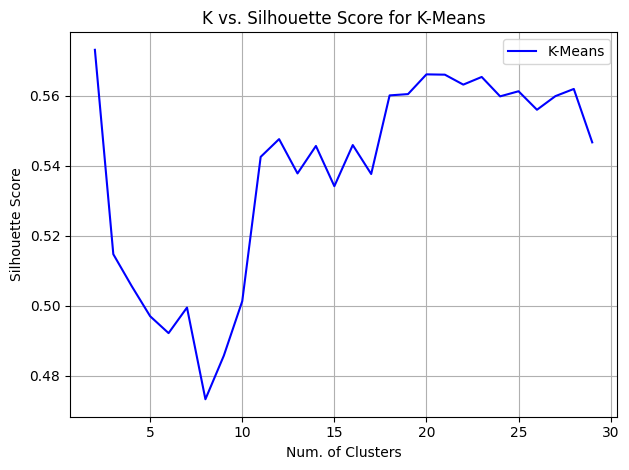

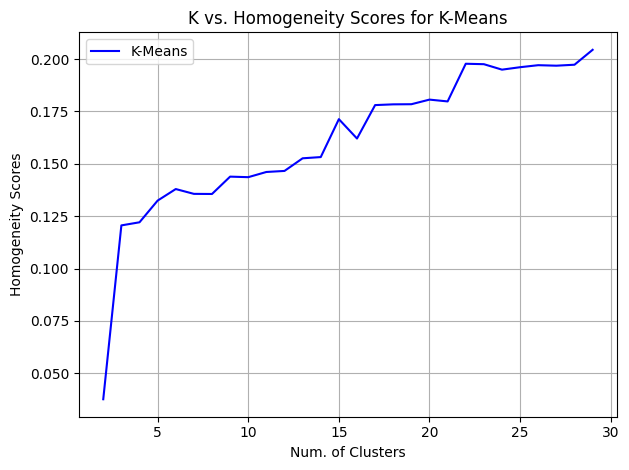

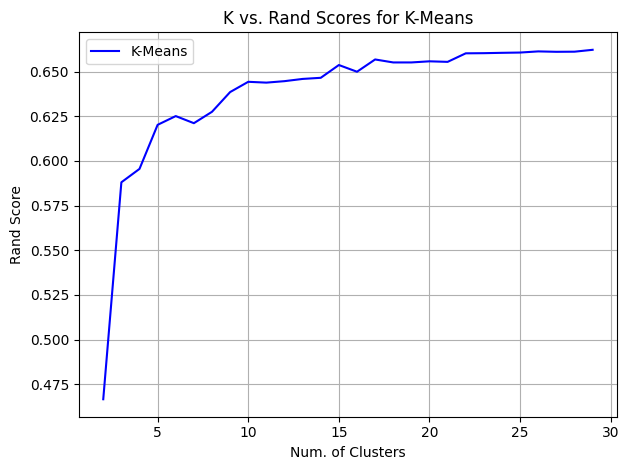

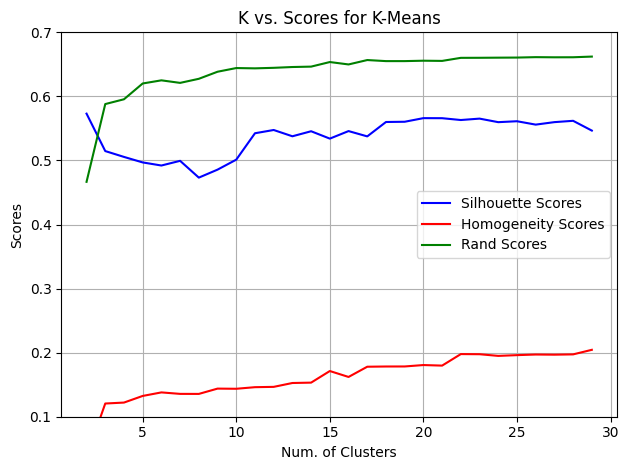

In [16]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(X)
    sil_scores.append(silhouette_score(X, kmeans.labels_))
    hom_scores.append(homogeneity_score(y, kmeans.labels_))
    ran_scores.append(rand_score(y, kmeans.labels_))
    

plt.plot(k_values, sil_scores, color="blue", label="K-Means")
plt.title("K vs. Silhouette Score for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Silhouette Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(k_values, hom_scores, color="blue", label="K-Means")
plt.title("K vs. Homogeneity Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Homogeneity Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(k_values, ran_scores, color="blue", label="K-Means")
plt.title("K vs. Rand Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Rand Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()


plt.plot(k_values, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(k_values, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(k_values, ran_scores, color="green", label="Rand Scores")
plt.title("K vs. Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.ylim([.1, .7])
plt.tight_layout()
plt.grid()
plt.show()

In [17]:
print(sil_scores[18])
print(hom_scores[18])
print(ran_scores[18])

0.5660586438567924
0.1806532366247176
0.6557083534081263


***
### 1.2 Expectation Maximization on dataset #1
*** 

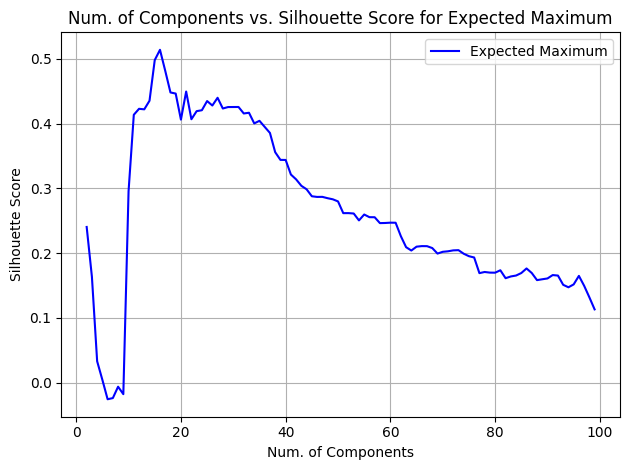

In [18]:
"""
Expectation Maximization

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 100, 1)
sil_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(X)
    labels_ = em.predict(X)
    sil_scores.append(silhouette_score(X, labels_))
    

plt.plot(num_components, sil_scores, color="blue", label="Expected Maximum")
plt.title("Num. of Components vs. Silhouette Score for Expected Maximum".format())
plt.xlabel("Num. of Components"), plt.ylabel("Silhouette Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

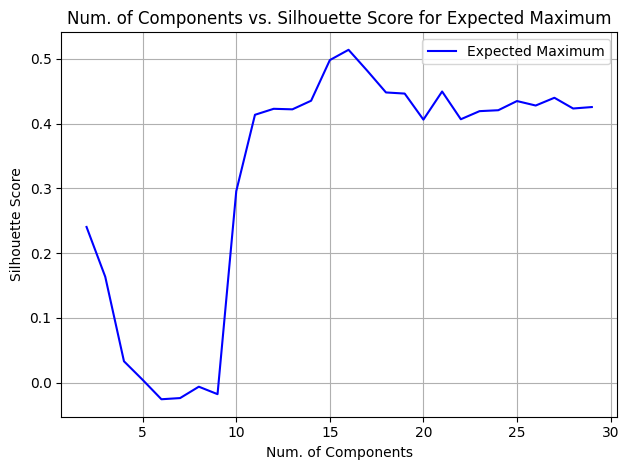

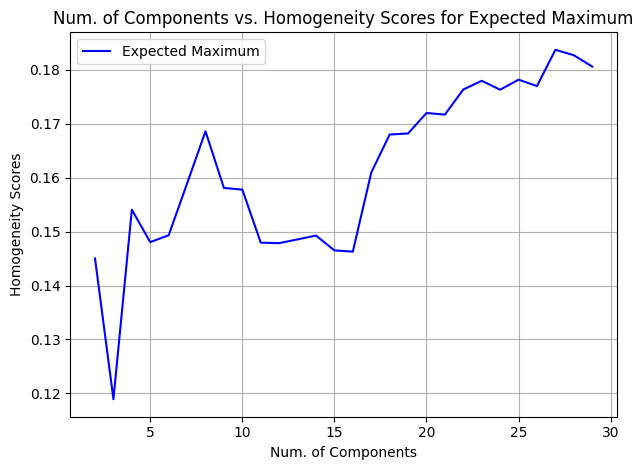

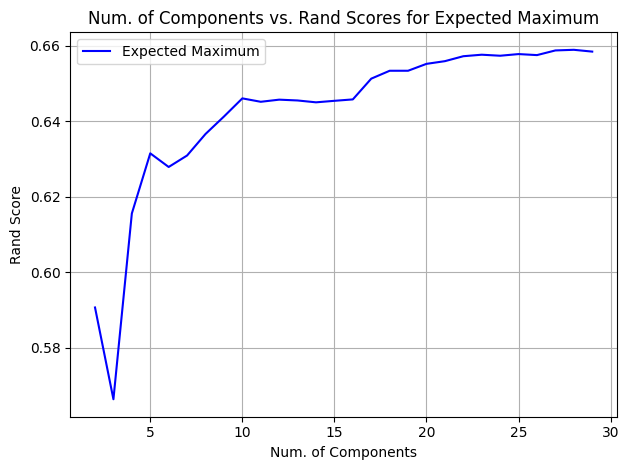

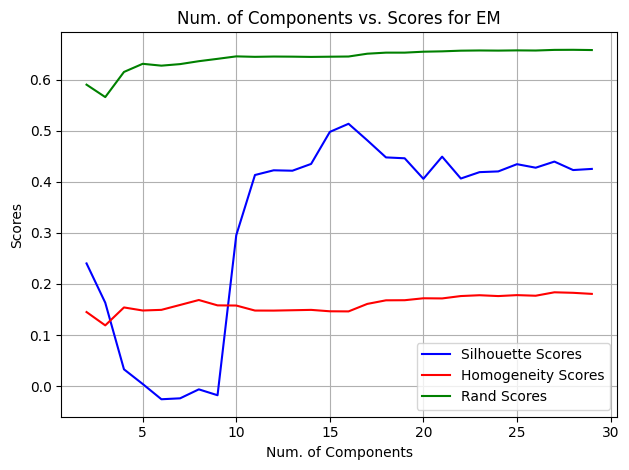

In [19]:
"""
Expectation Maximization

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(X)
    labels_ = em.predict(X)
    sil_scores.append(silhouette_score(X, labels_))
    hom_scores.append(homogeneity_score(y, labels_))
    ran_scores.append(rand_score(y, labels_))
    

plt.plot(num_components, sil_scores, color="blue", label="Expected Maximum")
plt.title("Num. of Components vs. Silhouette Score for Expected Maximum".format())
plt.xlabel("Num. of Components"), plt.ylabel("Silhouette Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(num_components, hom_scores, color="blue", label="Expected Maximum")
plt.title("Num. of Components vs. Homogeneity Scores for Expected Maximum".format())
plt.xlabel("Num. of Components"), plt.ylabel("Homogeneity Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(num_components, ran_scores, color="blue", label="Expected Maximum")
plt.title("Num. of Components vs. Rand Scores for Expected Maximum".format())
plt.xlabel("Num. of Components"), plt.ylabel("Rand Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(num_components, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(num_components, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(num_components, ran_scores, color="green", label="Rand Scores")
plt.title("Num. of Components vs. Scores for EM".format())
plt.xlabel("Num. of Components"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [20]:
print(sil_scores[14])
print(hom_scores[14])
print(ran_scores[14])

0.5139838979244369
0.14629174906967604
0.6458121687659164


*** 
## PART II: Dimensionality Reduction Algorithms
***
***
### 2.1 PCA on dataset #1
*** 

Eigenvalues of each Component: [209.29373573  31.59801305   3.55167632   3.29551977   2.0946747
   1.428431     1.32036313   0.78526903]


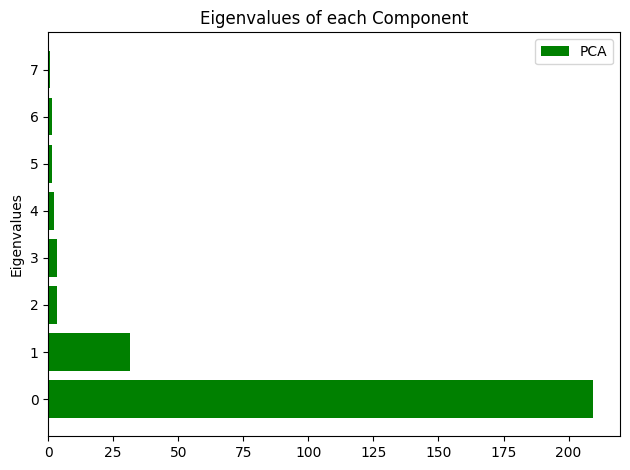

Eigenvalues of each Component: [209.29373573  31.59801305   3.55167632   3.29551977   2.0946747
   1.428431     1.32036313   0.78526903]
Total Eigenvalues 253.36768274631254
Eigenvalue Percent makeup of each Component [0.82604748 0.12471209 0.01401787 0.01300687 0.00826733 0.00563778
 0.00521125 0.00309933]


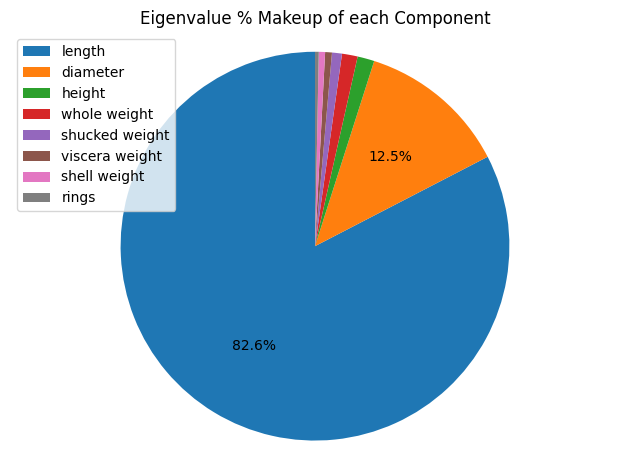

dummy classifier performance WITHOUT dimensionality reduction:
Total Training Time: 0.015s
Total Testing Time: 0.001s
Accuracy using test set: 0.4820574162679426
              precision    recall  f1-score   support

           F       0.39      0.39      0.39       261
           I       0.66      0.60      0.63       278
           M       0.41      0.45      0.43       297

    accuracy                           0.48       836
   macro avg       0.49      0.48      0.48       836
weighted avg       0.49      0.48      0.48       836

dummy classifier performance WITH dimensionality reduction:
Total Training Time: 0.007s
Total Testing Time: 0.0s
Accuracy using test set: 0.4796650717703349
              precision    recall  f1-score   support

           F       0.41      0.42      0.41       261
           I       0.65      0.63      0.64       278
           M       0.39      0.39      0.39       297

    accuracy                           0.48       836
   macro avg       0.48     

In [21]:
"""
PCA

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- 

Office Hour Notes:
- Must use variance - Maximize variance to find a projection of these axes which are orthogonal
to each other. Do this by looking at the distribution of the Eigenvalues and look for the components 
that have the highest Eigenvalues. Another way is to look for a surrogate that takes into account 
the Eigenvalues (such as explain variance)
- Run PCA on original x-train and you get a fit of PCA, then you run transform on that x-train and 
you get x-prime train. You use dummy classifier to fit x-train and x-prime train to see if there’s
a difference. Use default parameters for this. 

"""

n_features = X.shape[1]
column_names = df.columns[1:].values.tolist()
pca_obj = PCA(random_state=37)
pca_obj.fit(X)

# Find and plot the Eigenvalues of each component (bar)
eigenvalues = pca_obj.singular_values_
print("Eigenvalues of each Component:", eigenvalues)
plt.barh(np.arange(0, n_features), eigenvalues, color='g', label="PCA")
plt.title("Eigenvalues of each Component".format())
plt.ylabel("Eigenvalues"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# custom percentage filter to avoid overwrite
def perc_filter_10(pct):
    return ('%1.1f%%' %pct) if pct > 10 else ''

# Find and plot the Eigenvalues of each component (pie)
eigenvalues = pca_obj.singular_values_
print("Eigenvalues of each Component:", eigenvalues)
total_eigen = np.sum(eigenvalues)
print("Total Eigenvalues", total_eigen)
eigen_perc = eigenvalues/total_eigen
print("Eigenvalue Percent makeup of each Component", eigen_perc)
fig1, ax1 = plt.subplots()
ax1.pie(eigen_perc, autopct=perc_filter_10, startangle=90)
ax1.axis('equal')
plt.title("Eigenvalue % Makeup of each Component".format())
plt.legend(column_names)
plt.tight_layout()
plt.show()    


# do dimensionality reduction with optimal n_components
pca_obj = PCA(n_components=2, random_state=37)
pca_x_transformed = pca_obj.fit_transform(X)
# split train and test
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_x_transformed, y, test_size=0.2, random_state=37)

# evaluate output of dimensionality reduction
print("dummy classifier performance WITHOUT dimensionality reduction:")
run_dummy_classifier(X_train, y_train, X_test, y_test)
print("dummy classifier performance WITH dimensionality reduction:")
run_dummy_classifier(pca_X_train, pca_y_train, pca_X_test, pca_y_test)

***
### 2.2 ICA on dataset #1
*** 

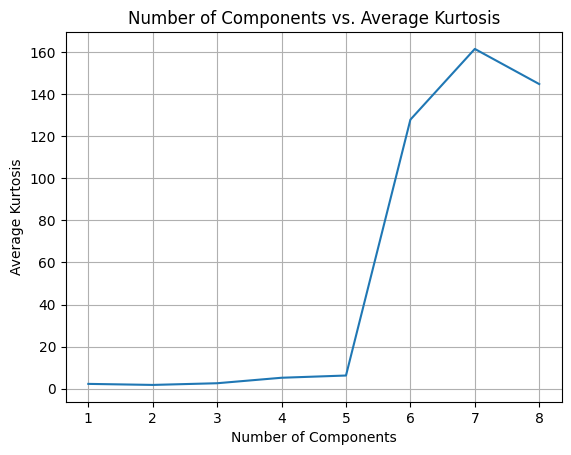

dummy classifier performance WITHOUT dimensionality reduction:
Total Training Time: 0.015s
Total Testing Time: 0.0s
Accuracy using test set: 0.4820574162679426
              precision    recall  f1-score   support

           F       0.39      0.39      0.39       261
           I       0.66      0.60      0.63       278
           M       0.41      0.45      0.43       297

    accuracy                           0.48       836
   macro avg       0.49      0.48      0.48       836
weighted avg       0.49      0.48      0.48       836

dummy classifier performance WITH dimensionality reduction:
Total Training Time: 0.016s
Total Testing Time: 0.0s
Accuracy using test set: 0.5191387559808612
              precision    recall  f1-score   support

           F       0.45      0.46      0.46       261
           I       0.66      0.63      0.65       278
           M       0.45      0.47      0.46       297

    accuracy                           0.52       836
   macro avg       0.52      0

In [22]:
"""
ICA

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

Office Hour Notes:
Must use kurtosis - Maximize kurtosis to get a projection that is maximizing independence of your original feature space. 2 ways to do this:
1) Look at the kurtosis of each individual component then pick and choose the components that maximize kurtosis
2) Take the average and look at n-components for that average and choose a number that maximizes that average. 
TA mentioned you will likely run into a situation where the n-components that maximize kurtosis are equal to the number of features. In that case, some thresholding is required since the goal is to reduce the total number of features. 

"""

n_features = X.shape[1]
average_kurt_list = []

for n in range(1, n_features+1):
    ica_obj = fica(n_components=n, random_state=37)
    x_transformed = ica_obj.fit_transform(X)
    kurts_of_each = kurtosis(x_transformed, axis=0, fisher=True)
    abs_kurt_of_each = np.absolute(kurts_of_each)
    average_kurt = np.mean(abs_kurt_of_each)
    average_kurt_list.append(average_kurt)
    
# Find and plot the kurtosis at each n components 
plt.plot(np.arange(1, n_features+1), average_kurt_list)
plt.title("Number of Components vs. Average Kurtosis".format())
plt.xlabel("Number of Components"), plt.ylabel("Average Kurtosis")
plt.grid()
plt.show()


# do dimensionality reduction with optimal n_components
ica_obj = fica(n_components=7, random_state=37)
ica_x_transformed = ica_obj.fit_transform(X)
# split train and test
ica_X_train, ica_X_test, ica_y_train, ica_y_test = train_test_split(ica_x_transformed, y, test_size=0.2, random_state=37)

# evaluate output of dimensionality reduction
print("dummy classifier performance WITHOUT dimensionality reduction:")
run_dummy_classifier(X_train, y_train, X_test, y_test)
print("dummy classifier performance WITH dimensionality reduction:")
run_dummy_classifier(ica_X_train, ica_y_train, ica_X_test, ica_y_test)

***
### 2.3 RP on dataset #1
*** 

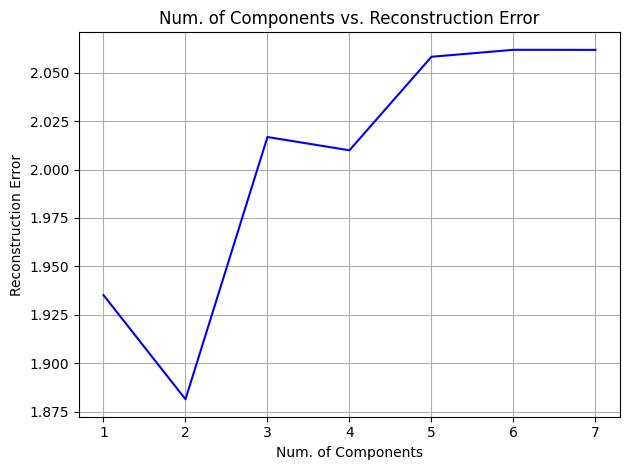

dummy classifier performance WITHOUT dimensionality reduction:
Total Training Time: 0.015s
Total Testing Time: 0.0s
Accuracy using test set: 0.4820574162679426
              precision    recall  f1-score   support

           F       0.39      0.39      0.39       261
           I       0.66      0.60      0.63       278
           M       0.41      0.45      0.43       297

    accuracy                           0.48       836
   macro avg       0.49      0.48      0.48       836
weighted avg       0.49      0.48      0.48       836

dummy classifier performance WITH dimensionality reduction:
Total Training Time: 0.00697s
Total Testing Time: 0.0s
Accuracy using test set: 0.48564593301435405
              precision    recall  f1-score   support

           F       0.41      0.46      0.44       261
           I       0.63      0.60      0.62       278
           M       0.43      0.40      0.41       297

    accuracy                           0.49       836
   macro avg       0.49    

In [23]:
"""
RP

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html
- https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html
- https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.johnson_lindenstrauss_min_dim.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

Office Hour Notes:
- Use reconstruction error (you can use this for other algorithms as well but definitely use it for random projection). 
- This value is the error between the original and the reconstructed data. 
- To get the reconstruction error, you need to take the pseudo inverse of the projection matrix. 
*this might be complicated, so TA said he would post some pseudo code on ed discussion to help if needed so look for it. (e.g. https://stats.stackexchange.com/questions/402121/sklearnpca-inverse-transformtransformx-x )
* Thresholding means something like choose a % for your explained variance

Goal:
- Determine n_components that result in the smallest total RMSE

"""

n_features = X.shape[1]

total_rmse_list = []
for n in range(1, n_features):
    # generate forward projection matrix using Gaussian Random Projection
    grp_obj = grp(n_components=n, compute_inverse_components=True, random_state=37)
    projection_data = grp_obj.fit_transform(X)
    #print("Forward Projection Data: ", projection_data)
    #print("Shape of Projection Data: ", projection_data.shape)

    # project data back to its original space via a pseudo inverse
    reconstructed_data = grp_obj.inverse_transform(projection_data)
    #print("Reconstructed Data: ", reconstructed_data)
    #print("Shape of Reconstructed Data: ", reconstructed_data.shape)

    # calculate RMSE between original and reconstructed data
    rmse = mean_squared_error(y_true=X, 
                              y_pred=reconstructed_data,
                             squared=False)
    total_rmse_list.append(rmse)
    #print("Total RMSE: ", rmse)
    
# plot n_components vs RMSE
plt.plot(range(1, n_features), total_rmse_list, color="blue")
plt.title("Num. of Components vs. Reconstruction Error".format())
plt.xlabel("Num. of Components"), plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.grid()
plt.show()  

# do dimensionality reduction with optimal n_components
grp_obj = grp(n_components=2, compute_inverse_components=True, random_state=37)
rp_x_transformed = grp_obj.fit_transform(X)
# split train and test
rp_X_train, rp_X_test, rp_y_train, rp_y_test = train_test_split(rp_x_transformed, y, test_size=0.2, random_state=37)

# evaluate output of dimensionality reduction
print("dummy classifier performance WITHOUT dimensionality reduction:")
run_dummy_classifier(X_train, y_train, X_test, y_test)
print("dummy classifier performance WITH dimensionality reduction:")
run_dummy_classifier(rp_X_train, rp_y_train, rp_X_test, rp_y_test)

***
### 2.4 RF on dataset #1
*** 

Total importances 1.0
Importance Percent makeup of each Component [0.09875814 0.1012306  0.09108052 0.1641082  0.13818549 0.17338775
 0.13833604 0.09491326]


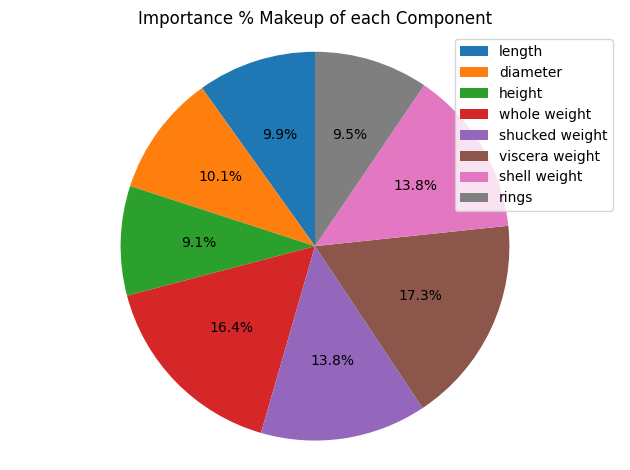

dummy classifier performance WITHOUT dimensionality reduction:
Total Training Time: 0.01938s
Total Testing Time: 0.001s
Accuracy using test set: 0.4820574162679426
              precision    recall  f1-score   support

           F       0.39      0.39      0.39       261
           I       0.66      0.60      0.63       278
           M       0.41      0.45      0.43       297

    accuracy                           0.48       836
   macro avg       0.49      0.48      0.48       836
weighted avg       0.49      0.48      0.48       836

dummy classifier performance WITH dimensionality reduction:
Total Training Time: 0.013s
Total Testing Time: 0.0s
Accuracy using test set: 0.5119617224880383
              precision    recall  f1-score   support

           F       0.43      0.45      0.44       261
           I       0.68      0.62      0.65       278
           M       0.44      0.47      0.46       297

    accuracy                           0.51       836
   macro avg       0.52   

In [24]:
"""
RF

Source:
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Office Hour Notes:
- TA highly recommends we use a supervised algorithm as it will be interesting. 
- In Office Hour #9, TA suggested we use random forests to pick the best features and 
compare accuracy - you can show accuracy using a table. 

"""

column_names = df.columns[1:].values.tolist()
rf_obj = RandomForestClassifier(random_state=37)
rf_obj.fit(X, y)
importances = rf_obj.feature_importances_

# custom percentage filter to avoid overwrite
def perc_filter_5(pct):
    return ('%1.1f%%' %pct) if pct > 5 else ''

# Find and plot the mean decrease in impurity of each component
total_importances = np.sum(importances)
print("Total importances", total_importances)
importance_perc = importances/total_importances
print("Importance Percent makeup of each Component", importance_perc)
fig1, ax1 = plt.subplots()
ax1.pie(importance_perc, autopct=perc_filter_5, startangle=90)
ax1.axis('equal')
plt.title("Importance % Makeup of each Component".format())
plt.legend(column_names)
plt.tight_layout()
plt.show()    

# do dimensionality reduction with optimal combination
rf_x_transformed = np.delete(X, 2, 1)
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_x_transformed, y, test_size=0.2, random_state=37)

# evaluate output of dimensionality reduction
print("dummy classifier performance WITHOUT dimensionality reduction:")
run_dummy_classifier(X_train, y_train, X_test, y_test)
print("dummy classifier performance WITH dimensionality reduction:")
run_dummy_classifier(rf_X_train, rf_y_train, rf_X_test, rf_y_test)

*** 
## PART III: Clustering Algorithms on Dimensionality Reduced Dataset
***

***
### KM on PCA on dataset #1
*** 

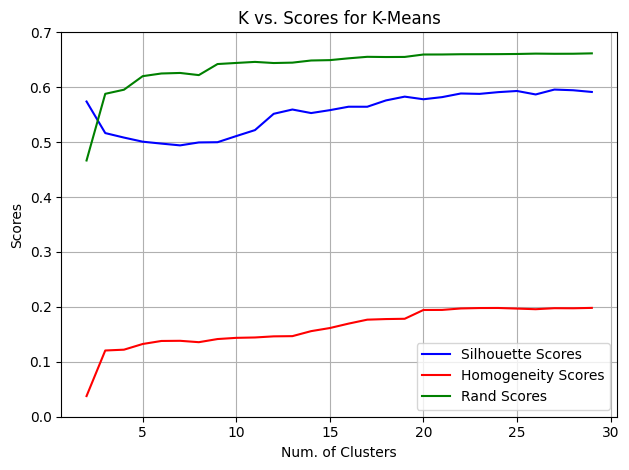

maximum silhouette score:  0.5957726951039357
k-value  27
homogeneity score at index of max silhouette score:  0.19764245409341835
rand score at index of max silhouette score:  0.660930552687728


In [25]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(pca_x_transformed)
    sil_scores.append(silhouette_score(pca_x_transformed, kmeans.labels_))
    hom_scores.append(homogeneity_score(y, kmeans.labels_))
    ran_scores.append(rand_score(y, kmeans.labels_))
    
plt.plot(k_values, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(k_values, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(k_values, ran_scores, color="green", label="Rand Scores")
plt.title("K vs. Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.ylim([0, .7])
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### KM on ICA on dataset #1
*** 

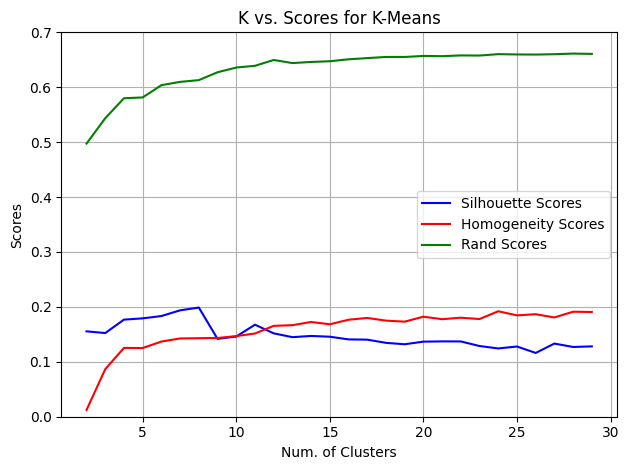

maximum silhouette score:  0.19881535430199687
k-value  8
homogeneity score at index of max silhouette score:  0.14301065726936565
rand score at index of max silhouette score:  0.6129885057471265


In [26]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(ica_x_transformed)
    sil_scores.append(silhouette_score(ica_x_transformed, kmeans.labels_))
    hom_scores.append(homogeneity_score(y, kmeans.labels_))
    ran_scores.append(rand_score(y, kmeans.labels_))
    
plt.plot(k_values, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(k_values, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(k_values, ran_scores, color="green", label="Rand Scores")
plt.title("K vs. Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.ylim([0, .7])
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### KM on RP on dataset #1
*** 

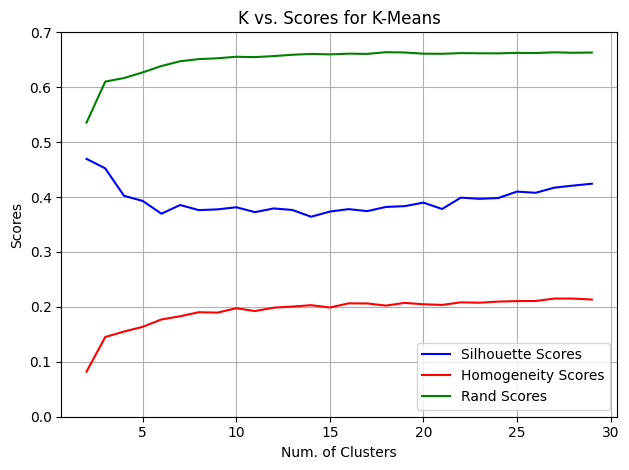

maximum silhouette score:  0.4695619013383086
k-value  2
homogeneity score at index of max silhouette score:  0.08219552368080967
rand score at index of max silhouette score:  0.5356121091151032


In [27]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(rp_x_transformed)
    sil_scores.append(silhouette_score(rp_x_transformed, kmeans.labels_))
    hom_scores.append(homogeneity_score(y, kmeans.labels_))
    ran_scores.append(rand_score(y, kmeans.labels_))
    
plt.plot(k_values, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(k_values, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(k_values, ran_scores, color="green", label="Rand Scores")
plt.title("K vs. Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.ylim([0, .7])
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### KM on RF on dataset #1
*** 

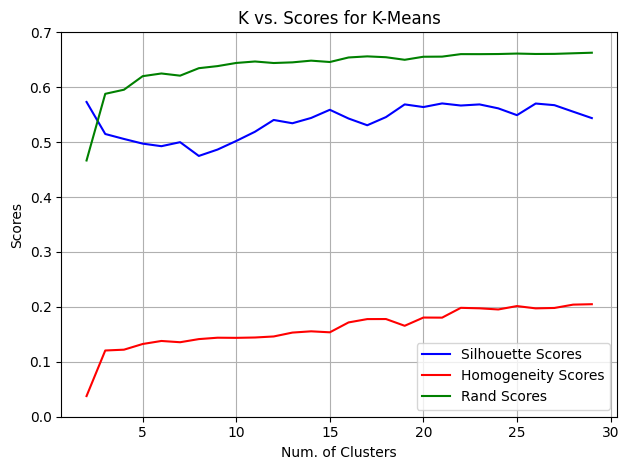

maximum silhouette score:  0.5732024714039229
k-value  2
homogeneity score at index of max silhouette score:  0.037604712580836176
rand score at index of max silhouette score:  0.4666276642118063


In [28]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

k_values = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=37)
    kmeans.fit(rf_x_transformed)
    sil_scores.append(silhouette_score(rf_x_transformed, kmeans.labels_))
    hom_scores.append(homogeneity_score(y, kmeans.labels_))
    ran_scores.append(rand_score(y, kmeans.labels_))
    
plt.plot(k_values, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(k_values, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(k_values, ran_scores, color="green", label="Rand Scores")
plt.title("K vs. Scores for K-Means".format())
plt.xlabel("Num. of Clusters"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.ylim([0, .7])
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### EM on PCA on dataset #1
*** 

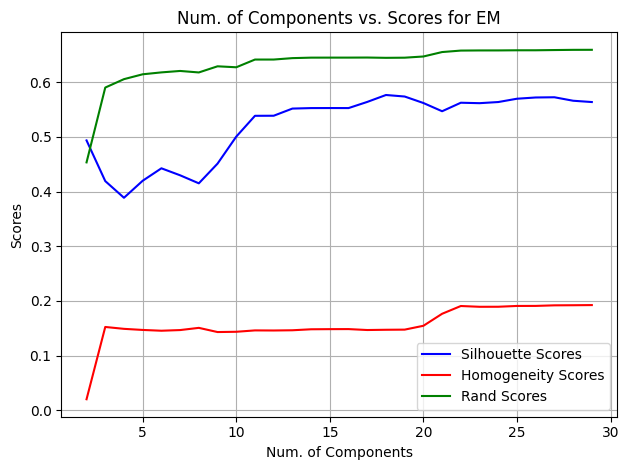

maximum silhouette score:  0.5766728766156489
k-value  18
homogeneity score at index of max silhouette score:  0.1471028082323354
rand score at index of max silhouette score:  0.6446747883543258


In [29]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(pca_x_transformed)
    labels_ = em.predict(pca_x_transformed)
    sil_scores.append(silhouette_score(pca_x_transformed, labels_))
    hom_scores.append(homogeneity_score(y, labels_))
    ran_scores.append(rand_score(y, labels_))
    
    
plt.plot(num_components, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(num_components, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(num_components, ran_scores, color="green", label="Rand Scores")
plt.title("Num. of Components vs. Scores for EM".format())
plt.xlabel("Num. of Components"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### EM on ICA on dataset #1
*** 

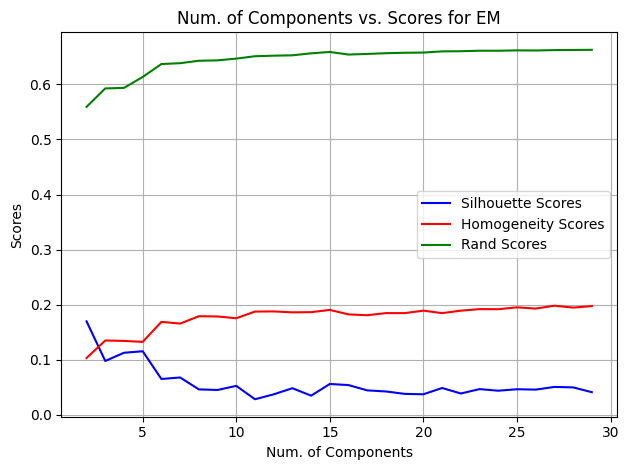

maximum silhouette score:  0.16981103373060855
k-value  2
homogeneity score at index of max silhouette score:  0.1033251191170092
rand score at index of max silhouette score:  0.5591924197581848


In [30]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(ica_x_transformed)
    labels_ = em.predict(ica_x_transformed)
    sil_scores.append(silhouette_score(ica_x_transformed, labels_))
    hom_scores.append(homogeneity_score(y, labels_))
    ran_scores.append(rand_score(y, labels_))
    
    
plt.plot(num_components, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(num_components, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(num_components, ran_scores, color="green", label="Rand Scores")
plt.title("Num. of Components vs. Scores for EM".format())
plt.xlabel("Num. of Components"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### EM on RP on dataset #1
*** 

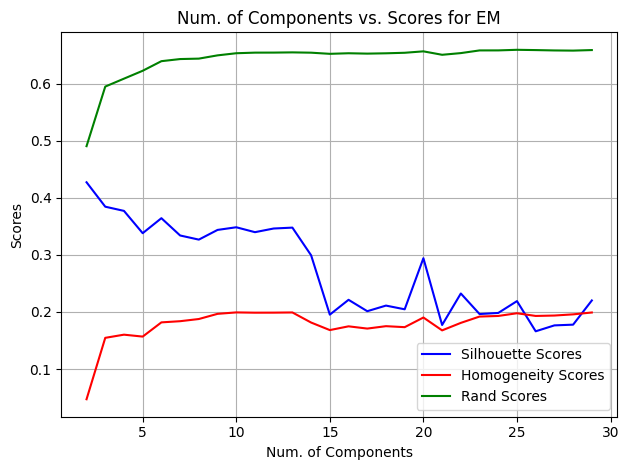

maximum silhouette score:  0.4272634995262698
k-value  2
homogeneity score at index of max silhouette score:  0.04706379502408072
rand score at index of max silhouette score:  0.49051506183036225


In [31]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(rp_x_transformed)
    labels_ = em.predict(rp_x_transformed)
    sil_scores.append(silhouette_score(rp_x_transformed, labels_))
    hom_scores.append(homogeneity_score(y, labels_))
    ran_scores.append(rand_score(y, labels_))
    
    
plt.plot(num_components, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(num_components, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(num_components, ran_scores, color="green", label="Rand Scores")
plt.title("Num. of Components vs. Scores for EM".format())
plt.xlabel("Num. of Components"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

***
### EM on RF on dataset #1
*** 

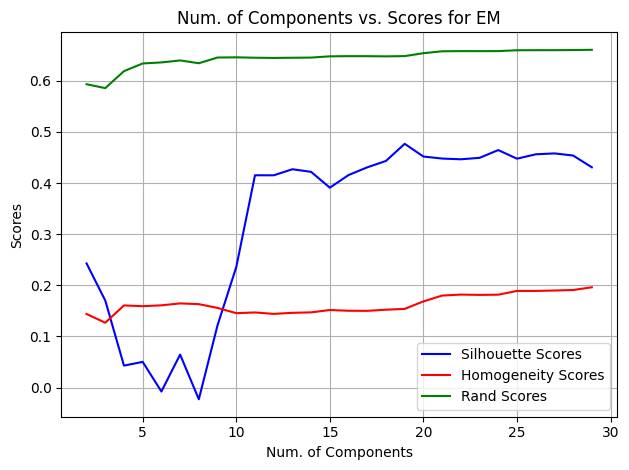

maximum silhouette score:  0.47679638666290836
k-value  19
homogeneity score at index of max silhouette score:  0.1539327254640287
rand score at index of max silhouette score:  0.6483459517746117


In [32]:
"""
K-Means Clustering

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html


"""

num_components = np.arange(2, 30, 1)
sil_scores = []
hom_scores = []
ran_scores = []

for n in num_components:
    em = expected_max(n_components=n, 
                      covariance_type='full', 
                      tol=1e-3,
                      reg_covar=1e-6,
                      max_iter=100,
                      n_init=1,
                      random_state=37,
                      warm_start=True)
    em.fit(rf_x_transformed)
    labels_ = em.predict(rf_x_transformed)
    sil_scores.append(silhouette_score(rf_x_transformed, labels_))
    hom_scores.append(homogeneity_score(y, labels_))
    ran_scores.append(rand_score(y, labels_))
    
    
plt.plot(num_components, sil_scores, color="blue", label="Silhouette Scores")
plt.plot(num_components, hom_scores, color="red", label="Homogeneity Scores")
plt.plot(num_components, ran_scores, color="green", label="Rand Scores")
plt.title("Num. of Components vs. Scores for EM".format())
plt.xlabel("Num. of Components"), plt.ylabel("Scores"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

max_sil_score = max(sil_scores)
index_at_max_sil_score = sil_scores.index(max_sil_score)
k_value = index_at_max_sil_score+2
print("maximum silhouette score: ", max_sil_score)
print("k-value ", k_value)
print("homogeneity score at index of max silhouette score: ", hom_scores[index_at_max_sil_score])
print("rand score at index of max silhouette score: ", ran_scores[index_at_max_sil_score])

*** 
## PART V: Performance of Neural Network on Features derived from Clustering Algorithms
***

***
### KM on NN on dataset #1
*** 

[ 0 11 14 ...  8  2  6]
          0      1      2       3       4       5       6     7
0     0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700   7.0
1     0.530  0.420  0.135  0.6770  0.2565  0.1415  0.2100   9.0
2     0.440  0.365  0.125  0.5160  0.2155  0.1140  0.1550  10.0
3     0.330  0.255  0.080  0.2050  0.0895  0.0395  0.0550   7.0
4     0.425  0.300  0.095  0.3515  0.1410  0.0775  0.1200   8.0
...     ...    ...    ...     ...     ...     ...     ...   ...
4171  0.565  0.450  0.165  0.8870  0.3700  0.2390  0.2490  11.0
4172  0.590  0.440  0.135  0.9660  0.4390  0.2145  0.2605  10.0
4173  0.600  0.475  0.205  1.1760  0.5255  0.2875  0.3080   9.0
4174  0.625  0.485  0.150  1.0945  0.5310  0.2610  0.2960  10.0
4175  0.710  0.555  0.195  1.9485  0.9455  0.3765  0.4950  12.0

[4176 rows x 8 columns]
          0      1      2       3       4       5       6     7  kmc
0     0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700   7.0    0
1     0.530  0.420  0.135  0.6770  0.2565  0.

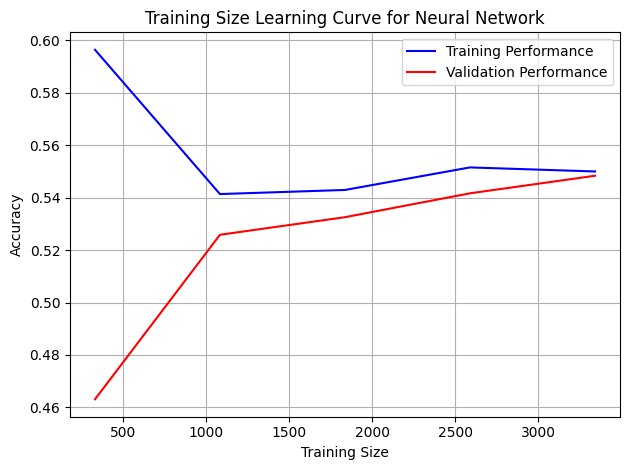

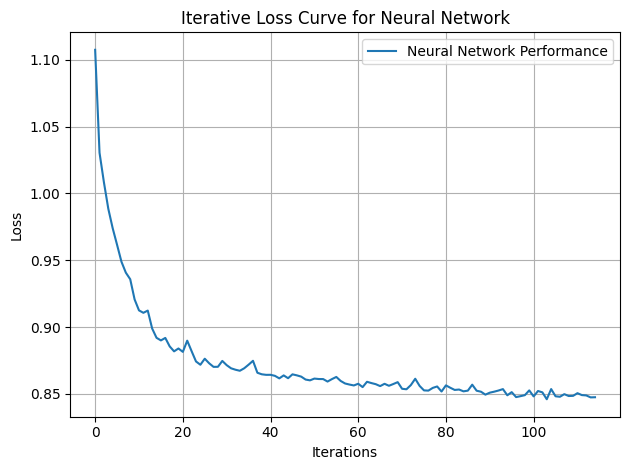

In [42]:
"""
Neural Network on KM (Default)    

"""

kmeans = KMeans(n_clusters=20, random_state=37)
kmeans.fit(X)
kmeans_labels = kmeans.labels_
print(kmeans_labels)

df = pd.DataFrame(X)
print(df)
df['kmc'] = kmeans_labels
print(df)
kmeans_X = np.array(df)
km_X_train, km_X_test, km_y_train, km_y_test = train_test_split(kmeans_X, y, test_size=0.2, random_state=37)

# initialize
mlp_clf = MLPClassifier(random_state=37)
# start timer for training
start = time.time()
# train classifier
mlp_clf.fit(km_X_train, km_y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = mlp_clf.predict(km_X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(km_y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(km_y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(mlp_clf, kmeans_X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# plot learning curve using training and validation data
get_learning_curve_size(clf=mlp_clf, clf_name="Neural Network", X=kmeans_X, y=y)
# plot loss curve using using training data
get_loss_curve(clf=mlp_clf, clf_name="Neural Network")

In [45]:
"""
Neural Network on KM (hyperparameter optimization and confirmation) using Gridsearch

"""

mlp_clf = MLPClassifier(random_state=37)

# list hyperparameters to compare
h_params = {
    'alpha':[0.0001, 0.0001, .001, .01, 1],
    'hidden_layer_sizes':[
        (100),
        (100, 100),
        (250),
        (250, 250),
        (500),
        (500, 500)
    ],
    'max_iter': [100, 200, 300]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(kmeans_X, y)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

According to gridsearch
Best parameter values: {'alpha': 0.001, 'hidden_layer_sizes': 100, 'max_iter': 100}
Best classifier: MLPClassifier(alpha=0.001, hidden_layer_sizes=100, max_iter=100,
              random_state=37)
Best score: 0.5510033521473799


***
### EM on NN on dataset #1
*** 

[ 7  4 11 ...  4 11 10]
          0      1      2       3       4       5       6     7
0     0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700   7.0
1     0.530  0.420  0.135  0.6770  0.2565  0.1415  0.2100   9.0
2     0.440  0.365  0.125  0.5160  0.2155  0.1140  0.1550  10.0
3     0.330  0.255  0.080  0.2050  0.0895  0.0395  0.0550   7.0
4     0.425  0.300  0.095  0.3515  0.1410  0.0775  0.1200   8.0
...     ...    ...    ...     ...     ...     ...     ...   ...
4171  0.565  0.450  0.165  0.8870  0.3700  0.2390  0.2490  11.0
4172  0.590  0.440  0.135  0.9660  0.4390  0.2145  0.2605  10.0
4173  0.600  0.475  0.205  1.1760  0.5255  0.2875  0.3080   9.0
4174  0.625  0.485  0.150  1.0945  0.5310  0.2610  0.2960  10.0
4175  0.710  0.555  0.195  1.9485  0.9455  0.3765  0.4950  12.0

[4176 rows x 8 columns]
          0      1      2       3       4       5       6     7  emc
0     0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700   7.0    7
1     0.530  0.420  0.135  0.6770  0.2565  0.

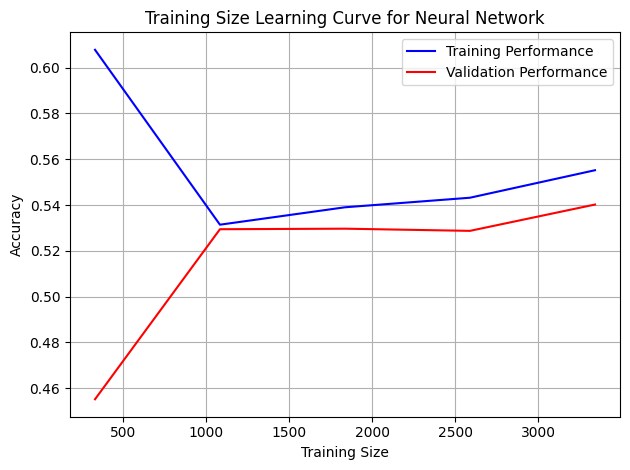

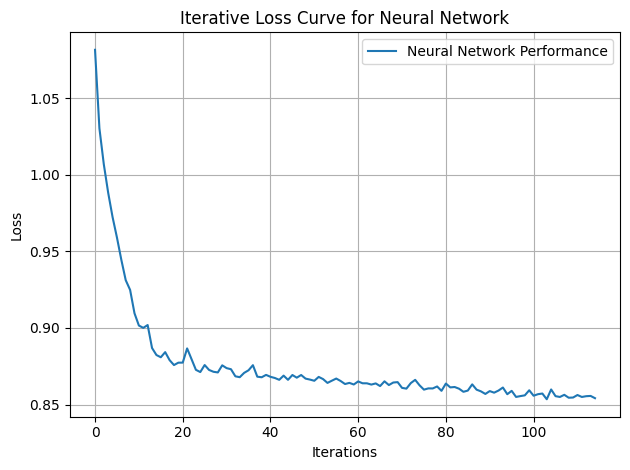

In [44]:
"""
Neural Network on EM (Default)    

"""
em = expected_max(n_components=16, 
                  covariance_type='full', 
                  tol=1e-3,
                  reg_covar=1e-6,
                  max_iter=100,
                  n_init=1,
                  random_state=37,
                  warm_start=True)
em.fit(X)
em_labels = em.predict(X)
print(em_labels)

df = pd.DataFrame(X)
print(df)
df['emc'] = em_labels
print(df)
em_X = np.array(df)
em_X_train, em_X_test, em_y_train, em_y_test = train_test_split(em_X, y, test_size=0.2, random_state=37)

# initialize
mlp_clf = MLPClassifier(random_state=37)
# start timer for training
start = time.time()
# train classifier
mlp_clf.fit(em_X_train, em_y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = mlp_clf.predict(em_X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(em_y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(em_y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(mlp_clf, em_X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# plot learning curve using training and validation data
get_learning_curve_size(clf=mlp_clf, clf_name="Neural Network", X=em_X, y=y)
# plot loss curve using using training data
get_loss_curve(clf=mlp_clf, clf_name="Neural Network")

In [46]:
"""
Neural Network on EM (hyperparameter optimization and confirmation) using Gridsearch

"""

mlp_clf = MLPClassifier(random_state=37)

# list hyperparameters to compare
h_params = {
    'alpha':[0.0001, 0.0001, .001, .01, 1],
    'hidden_layer_sizes':[
        (100),
        (100, 100),
        (250),
        (250, 250),
        (500),
        (500, 500)
    ],
    'max_iter': [100, 200, 300]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(em_X, y)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

According to gridsearch
Best parameter values: {'alpha': 0.001, 'hidden_layer_sizes': (250, 250), 'max_iter': 300}
Best classifier: MLPClassifier(alpha=0.001, hidden_layer_sizes=(250, 250), max_iter=300,
              random_state=37)
Best score: 0.5428627911640833
